# Modeling
Big notebook, lots of stuff.  I'm going to try to break it up into sections.

## Environment

In [1]:
import numpy as np
import pandas as pd

In [2]:
# show 100 rows max
pd.options.display.max_rows = 100

## Load Data

In [3]:
def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")

In [4]:
def print_rows(df):
    print(f"Rows: {df.shape[0]:,}")

In [5]:
data_dir = "/data/p_dsi/capstone_projects/shea/4_merged/"
filename = "merged_structured.pkl"

df = pd.read_pickle(data_dir + filename)
print_shape(df)

Rows: 13,074,852 
Columns: 42


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13074852 entries, 0 to 13074851
Data columns (total 42 columns):
 #   Column               Dtype         
---  ------               -----         
 0   vin                  object        
 1   price                float64       
 2   miles                float64       
 3   year                 float64       
 4   make                 object        
 5   model                object        
 6   trim                 object        
 7   vehicle_type         object        
 8   body_type            object        
 9   body_subtype         object        
 10  drivetrain           object        
 11  fuel_type            object        
 12  engine_block         object        
 13  engine_size          object        
 14  transmission         object        
 15  doors                float64       
 16  cylinders            float64       
 17  city_mpg             float64       
 18  highway_mpg          float64       
 19  base_exterior_color

Title registration is the source of truth for purchase date and price. Listing for everything else...

## Business Case Exclusions

### Consumer Cars and Trucks Only
Exclude commerical and recreational vehicles

In [7]:
# consumer cars and trucks
# df["body_type"].value_counts()

excluded_vehtypes = ["Cargo Van","Passenger Van","Chassis Cab","Car Van"
                     ,"Combi","Cutaway","Van","Commercial Wagon","Chassis Cowl"]

print(df["body_type"].isin(excluded_vehtypes).sum())
df = df[~df["body_type"].isin(excluded_vehtypes)]
print_shape(df)

135385
Rows: 12,939,467 
Columns: 42


### Not Vintage
Vehicles older than 20 years can qualify for an antique plate

In [8]:
# replace missing model year in listing with model year from mvr/registration
df.loc[df["year"].isna(),"year"] = df.loc[df["year"].isna(),"mvr_model_year"]
df["year"] = df["year"].astype("int") # convert to int

In [9]:
# drop missing purchase date
print(df["mvr_purchase_date"].isna().sum())
df = df[~(df["mvr_purchase_date"].isna())]
print_rows(df)

160
Rows: 12,939,307


In [10]:
# drop purchase date pre-2017
print((df["mvr_purchase_date"] < pd.to_datetime('20170101', format='%Y%m%d')).sum())
df = df[~(df["mvr_purchase_date"] < pd.to_datetime('20170101', format='%Y%m%d'))]
print_rows(df)

19466
Rows: 12,919,841


In [11]:
# difference between purchase date and 01-01-model_year
df["timedelta"] = df["mvr_purchase_date"] - pd.to_datetime(df['year'].astype(str) + '0101', format='%Y%m%d')

In [ ]:
# compute age in months
df["age_months"] = np.round(df['timedelta'].astype('timedelta64[s]') / (30.44*24*60*60)).astype(int)
df["age_months"] = df["age_months"] + 6 # model year release date factor

In [13]:
# drop 20+ years old
print((df["age_months"] >= 240).sum())
df = df[df["age_months"] < 240]
print_rows(df)

139048
Rows: 12,780,793


In [ ]:
# drop problematic negative age
print((df["age_months"] < 1).sum())
df = df[~(df["age_months"] < 1)]
print_rows(df)

### International

In [14]:
# canadians/mexicans
print((df["currency_indicator"] == "CAD").sum())
df = df[~(df["currency_indicator"] == "CAD")]

print((df["miles_indicator"] == "KILOMETERS").sum())
df = df[~(df["miles_indicator"] == "KILOMETERS")]


44
376


## Fatally Missing Values
Not appropriate to impute these since they're too important

### Price

In [15]:
# price missing
print(df["mvr_price"].isna().sum())
df = df[~df["mvr_price"].isna()]
print_rows(df)

942729
Rows: 11,837,644


In [16]:
# price ~ 0
print((df["mvr_price"] < 10).sum())
df = df[~(df["mvr_price"] < 10)]
print_rows(df)

2668980
Rows: 9,168,664


### Mileage

In [17]:
# replace missing listing miles with registration miles
df.loc[df["miles"].isna(),"miles"] = pd.to_numeric(df['mvr_mileage'], errors='coerce')[df["miles"].isna()]

In [18]:
# replace 0 listing miles with registration miles
df.loc[(df["miles"] == 0),"miles"] = pd.to_numeric(df['mvr_mileage'], errors='coerce')[df["miles"] == 0]

In [19]:
# drop if miles
print(df["miles"].isna().sum())
print((df["miles"] == 0).sum())
df = df[~(df["miles"].isna() | (df["miles"] == 0))]
print_rows(df)

32927
6121
Rows: 9,129,616


## Suspicious Data

### Listing Date vs Purchase Date

In [20]:
# difference between the last listing and the sale date recorded on the state registration
#df["list_sale_diff"] = (df['mvr_purchase_date'] - df['status_date']).astype('timedelta64[D]')
#print_shape(df)
# drop na's
#df.dropna(subset=["list_sale_diff"], inplace=True)
#print_shape(df)
# keep records with difference less than 90 days
#df = df[abs(df["list_sale_diff"]) < 90]
#print_shape(df)
#(abs(df["list_sale_diff"]) > 90).sum()

### Mileage

In [21]:
# TODO: Check high mileage against mvr mileage

In [22]:
# calculate high and low prices
top = df["miles"].quantile(0.999)
print(round(top))
bottom = df["miles"].quantile(0.001)
print(round(bottom))

302039
4


In [23]:
toptop = df["miles"].quantile(0.9999)
print(toptop)

617405.464999564


### Other Strange Values

In [24]:
df = df[df["drivetrain"].isin(["FWD", "RWD", "4WD"])]

In [25]:
mapping = {"Lpg / Natural Gas":"Natural Gas"
           ,"Unleaded / Premium Unleaded":"Premium Unleaded"
           ,"E85; Unleaded ":"E85 / Unleaded"
           ,"E85 / Unleaded; Premium Unleaded":"Premium Unleaded"
           ,"Compressed Natural Gas; Unleaded":"Natural Gas"
           ,"Unleaded; Unleaded / E85":"E85 / Unleaded"
           ,"E85 / Unleaded; Unleaded / E85 ":"E85 / Unleaded"
           ,"Unleaded / Electric":"Electric / Unleaded"
           ,"Compressed Natural Gas / Unleaded":"Natural Gas"
           ,"Premium Unleaded; Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded / Unleaded":"E85 / Unleaded"
           ,"Compressed Natural Gas":"Natural Gas"
           ,"Unleaded / Unleaded":"Unleaded"
           ,"Premium Unleaded / Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded":"E85 / Unleaded"
           ,"Unleaded / E85":"E85 / Unleaded"
          }

df['fuel_type'] = df['fuel_type'].map(mapping).fillna(df['fuel_type'])

In [ ]:
df['zip'] = df['zip'].str[:5]

## Make, Model, Trim
Central to target encoding. Need at least 1000 observations of make/model/trim combo

In [26]:
# make, model, or trim is null
print((df["make"].isna() | df["model"].isna() | df["trim"].isna()).sum())
df = df[~(df["make"].isna() | df["model"].isna() | df["trim"].isna())]
print_rows(df)

3183
Rows: 9,050,976


In [27]:
# new make/model/trim col
df['make_model_trim'] = df['make'] + ' / ' + df['model'] + ' / ' + df['trim']

In [28]:
# drop make/model/trim <100 obs
print(sum(df["make_model_trim"].value_counts()[df["make_model_trim"].value_counts() < 1000]))
df = df[~df['make_model_trim'].isin(list((df["make_model_trim"].value_counts()[df["make_model_trim"].value_counts() < 1000]).index))]
print_rows(df)

845579
Rows: 8,205,397


## Target Variable

We're not sellin' Ferraris and Lamborghinis here. We're sellin' everyday used cars.

In [29]:
df["mvr_price"].describe()

count    8.205397e+06
mean     2.134589e+05
std      3.468528e+08
min      1.000000e+01
25%      1.367665e+04
50%      2.081300e+04
75%      3.035068e+04
max      7.911790e+11
Name: mvr_price, dtype: float64

In [30]:
# calculate high and low prices
top = df["mvr_price"].quantile(0.999)
print(round(top))
bottom = df["mvr_price"].quantile(0.001)
print(round(bottom))

102750
100


In [31]:
toptop = df["mvr_price"].quantile(0.9999)
print(toptop)

215000.0


In [32]:
#df[(df["mvr_price"] > toptop)].sort_values(by=["mvr_price"])

Based on manual inspection, records with `mvr_price` over $300,000 become highly error-prone. Extensive data validation is beyond the scope of this project, and these records will be dumped.

In [33]:
# remove obvious data errors only
df = df[~(df["mvr_price"] > 300000)]

<AxesSubplot:>

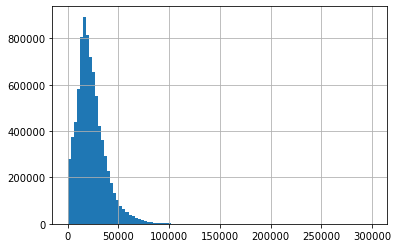

In [34]:
# plot distribution of mvr_price
df["mvr_price"].hist(bins=100)

## Subset Columns

In [35]:
df = df[['mvr_price','make_model_trim','miles', 'year','age_months', 'mvr_purchase_date',
       'vehicle_type', 'body_type', 'drivetrain', 'fuel_type',
       'engine_block', 'engine_size', 'transmission', 'doors', 'cylinders',
       'city_mpg', 'highway_mpg', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'zip','mvr_state',
       'hvf_standard', 'hvf_optional','make','model','trim']]

# numeric
df["engine_size"] = df["engine_size"].astype("float")

## Additional Feature Engineering

In [36]:
# purchase month
df["mvr_purchase_month"] = df["mvr_purchase_date"].dt.month.astype("category")

In [ ]:
# monthly mileage
df["monthly_mileage"] = round(df["miles"]/df["age_months"],1)

In [38]:
# epa weights city/highway 55/45
df["mpg"] = df["city_mpg"] * 0.55 + df["highway_mpg"] * 0.45
df.drop(columns=["city_mpg", "highway_mpg"], inplace=True)

### Local Features

In [39]:
from uszipcode import SearchEngine
search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive) 

In [40]:
def get_population_density_and_income(zipcode):
    result = search.by_zipcode(zipcode)
    if result:
        return pd.Series([result.population_density
                          ,result.median_household_income
                          ,result.median_home_value
                         ])
    else:
        return pd.Series([None, None, None])

In [41]:
# apply get_population_density_and_income to each value in zip_list
zip_list = pd.DataFrame(df['zip'].unique(), columns=['zip'])
zip_list[['population_density', 'median_income', 'median_home_value']] = zip_list['zip'].apply(get_population_density_and_income)
df = df.merge(zip_list, on='zip', how='left')

### Economic

In [42]:
df["mvr_purchase_yearmonth"] = df["mvr_purchase_date"].dt.strftime('%Y-%m')

In [43]:
# federal reserve economic data (fred)
from fredapi import Fred
fred = Fred(api_key_file='private/fred_api_key.txt')

#### Used Car Price Index

In [44]:
# BLS: Used cars and trucks in U.S. city average
used_car_price_index = fred.get_series('CUUR0000SETA02')
used_car_price_index.name = "used_car_price_index"
used_car_price_index.index = used_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
used_car_price_index.index = used_car_price_index.index.strftime('%Y-%m')
df = df.join(used_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### New Car Price Index

In [45]:
# BLS: New cars and trucks in U.S. city average
new_car_price_index = fred.get_series('CUSR0000SETA01')
new_car_price_index.name = "new_car_price_index"
new_car_price_index.index = new_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
new_car_price_index.index = new_car_price_index.index.strftime('%Y-%m')
df = df.join(new_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### Gas Prices

In [46]:
gas_price_index = fred.get_series('GASREGW')
gas_price_index.name = "gas_price_index"
gas_price_index = gas_price_index.groupby(pd.Grouper(freq='M')).mean().resample('M').mean()
gas_price_index.index = gas_price_index.index + pd.DateOffset(months=1) # shift index 
gas_price_index.index = gas_price_index.index.strftime('%Y-%m')
df = df.join(gas_price_index, on="mvr_purchase_yearmonth", how="left")

#### Consumer Sentiment

In [47]:
consumer_sentiment_index = fred.get_series('UMCSENT')
consumer_sentiment_index.name = "consumer_sentiment_index"
consumer_sentiment_index.index = consumer_sentiment_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
consumer_sentiment_index.index = consumer_sentiment_index.index.strftime('%Y-%m')
df = df.join(consumer_sentiment_index, on="mvr_purchase_yearmonth", how="left")

### "High Value Features" Vehicle Options

In [53]:
def make_series(x):
    return pd.Series(x, dtype = object)

In [54]:
from tqdm import tqdm
tqdm.pandas()

In [55]:
hvf_optional = df["hvf_optional"]

In [56]:
hvf_optional_df = pd.get_dummies(hvf_optional.progress_apply(make_series).stack()).groupby(level=0).sum()
print(hvf_optional_df.shape)

100%|██████████| 8205193/8205193 [38:51<00:00, 3518.98it/s]  


(2948489, 77)


,3rd Row Seats,4-Wheel Steering,Adaptive Cruise Control,Android Auto,Anti Collision System,Apple CarPlay,Automatic Transmission,Autonomous Drive Functions,Aux Jack Input,Backup Camera,...,Touch Screen Audio,Trailer Assist,Trailer Tow Mirrors,Turbo Boost,USB Connection,Video Entertainment,Voice Recognision,Voice Recognition,WiFi Hotspot,Wireless Charging/Connection
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
14,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
merged_df = df.join(hvf_optional_df, how="left")
hvf_cols = list(hvf_optional_df.columns)
merged_df[hvf_cols] = merged_df[hvf_cols].fillna(0)
print_shape(merged_df)

In [195]:
df = merged_df

In [338]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df.to_pickle(working_dir + "df.pkl")

## Data Split

In [ ]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df = pd.read_pickle(working_dir + "df.pkl")

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# shuffle dataframe for good measure
df = df.sample(frac=1).reset_index(drop=True)

# create StratifiedShuffleSplit object by make_model_trim column
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, temp_index = next(sss.split(df, df['make_model_trim']))

# create StratifiedShuffleSplit object by make_model_trim column again
df_temp = df.loc[temp_index]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
val_index, test_index = next(sss.split(df_temp, df_temp['make_model_trim']))

# split dataframe into train, validate, and test sets
train = df.loc[train_index]
validate = df.loc[temp_index[val_index]]
test = df.loc[temp_index[test_index]]

print("Train")
print_rows(train)
print("\nValidate")
print_rows(validate)
print("\nTest")
print_rows(test)


## Target Encoding

In [371]:
train["make_model_trim_encoded"] = train["make_model_trim"]
validate["make_model_trim_encoded"] = validate["make_model_trim"]
test["make_model_trim_encoded"] = test["make_model_trim"]

In [372]:
# fit encoder
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['make_model_trim_encoded'])
encoder.fit(train, train["mvr_price"])

TargetEncoder(cols=['make_model_trim_encoded'])

In [373]:
# transform
train = encoder.transform(train)
validate = encoder.transform(train)
test = encoder.transform(train)

## HVF Dimsionality Reduction

In [374]:
hvf_cols = ['3rd Row Seats',  '4-Wheel Steering',  'Adaptive Cruise Control', 'Android Auto',
 'Anti Collision System', 'Apple CarPlay', 'Automatic Transmission', 'Autonomous Drive Functions',
 'Aux Jack Input', 'Backup Camera', 'Biodiesel', 'Blind Spot System', 'Bluetooth', 'Brake Assist',
 'CVT Transmission', 'Collision/Breakdown Telematics', 'Coming Home Device',
 'Compressed Natural Gas', 'Concierge Services', 'Convertible Roof', 'Cruise Control', 'Diesel',
 'Directional Headlights', 'Dual Rear Wheels', 'Dynamic Steering', 'Electric', 'Fog Lights',
 'Gasoline', 'HDMI Connection', 'Hands Free Liftgate', 'Heads Up Display', 'Heated Door Mirrors',
 'Heated Seats', 'Heated/Cooled Seats', 'Hybrid', 'Keyless Entry/Locking', 'Keyless Start/Remote Engine Start',
 'LPG', 'Lane Keep Assist', 'Leather Seats', 'Leatherette Seats', 'Manual Transmission', 'Massage Seats',
 'Memory Mirrors', 'Memory Seats', 'Memory Steering Wheel Position', 'Mirrorlink', 'Navigation',
 'Panoramic Sun/Moonroof', 'Parking Assistance', 'Parking Distance Sensors', 'Parking Radar',
 'Parking distance system', 'Phone Integration', 'Pickup Bed Cover', 'Pickup Bed Extender', 'Pickup Bed Liner',
 'Power Closing Doors', 'Power Closing Liftgate', 'Premium Audio', 'Premium Cup Holders', 'Premium Wheels',
 'Rear/Multi-Zone Air Conditioning', 'Satellite Radio', 'Steering Wheel Controls', 'Sun/Moonroof',
 'Touch Screen', 'Touch Screen Audio', 'Trailer Assist', 'Trailer Tow Mirrors', 'Turbo Boost',
 'USB Connection', 'Video Entertainment', 'Voice Recognision', 'Voice Recognition', 'WiFi Hotspot',
            'Wireless Charging/Connection']

In [375]:
def reduce_hvf(df,hvf_cols,pca=None):
    subset_df = df[hvf_cols]
    
    # compute pca if not provided
    if not pca:
        pca = PCA(n_components=16)
        pca.fit(subset_df)
    
    transformed_subset = pca.transform(subset_df)
    transformed_subset = pd.DataFrame(transformed_subset, columns=['hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3'
                                                                ,'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6'
                                                                ,'hvf_comp_7', 'hvf_comp_8', 'hvf_comp_9'
                                                                ,'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12'
                                                                ,'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15'
                                                                ,'hvf_comp_16',])
    transformed_subset.index = df.index
    final_df = pd.concat([df.drop(columns=hvf_cols),transformed_subset], axis=1,ignore_index=False)
    print_shape(final_df)
    return final_df,pca

In [376]:
train,pca_train = reduce_hvf(train,hvf_cols)

Rows: 5,741,525 
Columns: 53


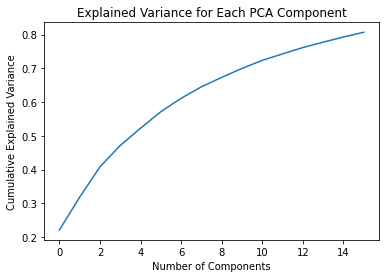

In [377]:
# plot the explained variance for each component
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance for Each PCA Component')
plt.show()

#loadings = pd.DataFrame(pca.components_.T, index=test_hvf.columns)
#for component in loadings.columns:
#    print(f'Top 5 loadings for {component}:')
#    print(loadings[component].abs().sort_values(ascending=False)[:5])
#    print('\n')


In [378]:
validate,_ = reduce_hvf(validate,hvf_cols,pca_train)

Rows: 5,741,525 
Columns: 53


In [379]:
test,_ = reduce_hvf(test,hvf_cols,pca_train)

Rows: 5,741,525 
Columns: 53


## Missing

In [380]:
# calculate percent missing for each field in df
def percent_missing(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    # Sort the table by percentage of missing descending
    mis_val_table = (
        mis_val_table[mis_val_table.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    # Print some summary information
    print(f"{mis_val_table.shape[0]} of {df.shape[1]} columns have missing values")
    # Return the dataframe with missing information
    return mis_val_table


In [381]:
# check for missing
print(percent_missing(train))
print(percent_missing(validate))
print(percent_missing(test))

18 of 53 columns have missing values
                     Missing Values  % of Total Values
hvf_optional                3677688               64.1
base_interior_color         1452484               25.3
is_certified                1254043               21.8
hvf_standard                1146129               20.0
base_exterior_color          523584                9.1
engine_block                 401655                7.0
cylinders                    401654                7.0
engine_size                  399846                7.0
mpg                          314513                5.5
median_income                 61111                1.1
population_density            61111                1.1
median_home_value             61111                1.1
transmission                   3071                0.1
vehicle_type                   1050                0.0
doors                           655                0.0
fuel_type                       655                0.0
body_type                   

### Simple Handling

In [382]:
# certified
train["is_certified"].fillna(0, inplace=True)
validate["is_certified"].fillna(0, inplace=True)
test["is_certified"].fillna(0, inplace=True)

In [383]:
# location info missing
train = train[~train["zip"].isna()]
validate = validate[~validate["zip"].isna()]
test = test[~test["zip"].isna()]

### Impute Mode for Categoricals

In [384]:
# categoricals
categoricals = ["base_interior_color","base_exterior_color","engine_block"
                ,"transmission","vehicle_type","fuel_type","body_type"
                ,"drivetrain"]
group = 'make_model_trim'
for cat in categoricals:
    train[cat] = train.groupby(group)[cat].transform(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'))
    validate[cat] = validate[group].map(train.groupby(group)[cat].apply(lambda x: x.mode()[0]))
    test[cat] = test[group].map(train.groupby(group)[cat].apply(lambda x: x.mode()[0]))

### Impute Median for Numerics

In [385]:
# numerics
numerics = ["cylinders","engine_size","mpg","doors"]
groups = ["make_model_trim","engine_size","cylinders","body_type"]
for group in groups:
    for num in numerics:
        train[num] = train.groupby(group)[num].transform(lambda x: x.fillna(x.median()))
        validate[num] = validate[group].map(train.groupby(group)[num].median())
        test[num] = test[group].map(train.groupby(group)[num].median())

### Impute Median for Zip Features

In [386]:
from sklearn.impute import SimpleImputer

# fit a median imputer on train
imputer = SimpleImputer(strategy='median')
imputer.fit(train[['population_density', 'median_income', 'median_home_value']])

# apply the median impute
train[['population_density', 'median_income', 'median_home_value']] = imputer.transform(train[['population_density', 'median_income', 'median_home_value']])
validate[['population_density', 'median_income', 'median_home_value']] = imputer.transform(validate[['population_density', 'median_income', 'median_home_value']])
test[['population_density', 'median_income', 'median_home_value']] = imputer.transform(test[['population_density', 'median_income', 'median_home_value']])


In [387]:
# check for missing
print(percent_missing(train))
print(percent_missing(validate))
print(percent_missing(test))

2 of 53 columns have missing values
              Missing Values  % of Total Values
hvf_optional         3677573               64.1
hvf_standard         1146092               20.0
2 of 53 columns have missing values
              Missing Values  % of Total Values
hvf_optional         3677573               64.1
hvf_standard         1146092               20.0
2 of 53 columns have missing values
              Missing Values  % of Total Values
hvf_optional         3677573               64.1
hvf_standard         1146092               20.0


## EDA

In [388]:
train.columns

Index(['mvr_price', 'make_model_trim', 'miles', 'year', 'age_months',
       'mvr_purchase_date', 'vehicle_type', 'body_type', 'drivetrain',
       'fuel_type', 'engine_block', 'engine_size', 'transmission', 'doors',
       'cylinders', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'zip', 'mvr_state', 'hvf_standard', 'hvf_optional',
       'make', 'model', 'trim', 'mvr_purchase_month', 'monthly_mileage', 'mpg',
       'population_density', 'median_income', 'median_home_value',
       'mvr_purchase_yearmonth', 'used_car_price_index', 'new_car_price_index',
       'gas_price_index', 'consumer_sentiment_index',
       'make_model_trim_encoded', 'hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3',
       'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6', 'hvf_comp_7', 'hvf_comp_8',
       'hvf_comp_9', 'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12',
       'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15', 'hvf_comp_16'],
      dtype='object')

In [389]:
# numerics correlations with target
correlations = train.corr(method="pearson", numeric_only=True)["mvr_price"].sort_values(ascending=False)
correlations

mvr_price                   1.000000
make_model_trim_encoded     0.786991
year                        0.615591
engine_size                 0.417529
cylinders                   0.384855
hvf_comp_1                  0.283747
used_car_price_index        0.172358
new_car_price_index         0.163203
gas_price_index             0.158832
is_certified                0.145099
hvf_comp_12                 0.136014
hvf_comp_16                 0.133637
hvf_comp_4                  0.115117
median_income               0.090053
median_home_value           0.085644
hvf_comp_9                  0.073823
monthly_mileage             0.058680
hvf_comp_15                 0.050475
hvf_comp_6                  0.030503
hvf_comp_7                  0.026758
doors                       0.011780
hvf_comp_13                 0.010883
hvf_comp_2                 -0.014236
hvf_comp_8                 -0.018010
hvf_comp_5                 -0.019134
hvf_comp_14                -0.023955
population_density         -0.024606
h

mvr_price         AxesSubplot(0.125,0.536818;0.133621x0.343182)
year           AxesSubplot(0.285345,0.536818;0.133621x0.343182)
engine_size     AxesSubplot(0.44569,0.536818;0.133621x0.343182)
cylinders      AxesSubplot(0.606034,0.536818;0.133621x0.343182)
doors          AxesSubplot(0.766379,0.536818;0.133621x0.343182)
mpg                  AxesSubplot(0.125,0.125;0.133621x0.343182)
miles             AxesSubplot(0.285345,0.125;0.133621x0.343182)
age_months         AxesSubplot(0.44569,0.125;0.133621x0.343182)
dtype: object

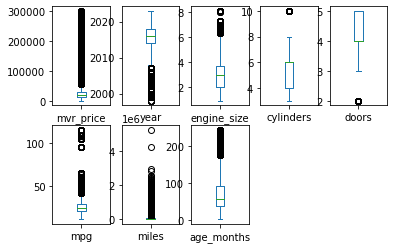

In [390]:
# boxplots of numeric variables
train[['mvr_price',
 'year',
 'engine_size',
 'cylinders',
 'doors',
 'mpg',
 'miles',
 'age_months']].plot(kind='box', subplots=True, layout=(2,5), sharex=False, sharey=False)

## Pre-Modeling EDA

In [391]:
print_shape(train)
train.sample(5).T


Rows: 5,741,342 
Columns: 53


,4862224,2103897,1393869,5486198,6337078
mvr_price,13999.0,12998.0,4950.0,51500.0,12760.0
make_model_trim,Toyota / Camry / LE,Toyota / Yaris iA / Base,Hyundai / Accent / GS,GMC / Yukon / Denali,Ford / Focus / S
miles,106978.0,25000.0,97759.0,80062.0,19659.0
year,2016,2017,2010,2015,2016
age_months,60,33,118,34,38
mvr_purchase_date,2020-06-24 00:00:00,2019-04-15 00:00:00,2019-04-30 00:00:00,2017-04-24 00:00:00,2018-09-05 00:00:00
vehicle_type,Car,Car,Car,Truck,Car
body_type,Sedan,Sedan,Hatchback,SUV,Sedan
drivetrain,FWD,FWD,FWD,4WD,FWD
fuel_type,Unleaded,Unleaded,Unleaded,Premium Unleaded,E85 / Unleaded


## Model

In [398]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def assess_results(y_test, y_pred):
    print("R2: ", round(r2_score(y_test, y_pred),3))
    print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
    print("MAPE: ", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,1),"%")
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print("Percent Underpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) >= 0]) / len(y_test) * 100,1),"%")
    print("Mean of Underpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) > 0]),2))
    print("Percent Overpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) < 0]) / len(y_test) * 100,1),"%")
    print("Mean of Overpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) < 0]),2))
    print("Mean Error: ", round(np.mean(y_test - y_pred),2)) 
    

### Column Inventory

In [393]:
train.columns

Index(['mvr_price', 'make_model_trim', 'miles', 'year', 'age_months',
       'mvr_purchase_date', 'vehicle_type', 'body_type', 'drivetrain',
       'fuel_type', 'engine_block', 'engine_size', 'transmission', 'doors',
       'cylinders', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'zip', 'mvr_state', 'hvf_standard', 'hvf_optional',
       'make', 'model', 'trim', 'mvr_purchase_month', 'monthly_mileage', 'mpg',
       'population_density', 'median_income', 'median_home_value',
       'mvr_purchase_yearmonth', 'used_car_price_index', 'new_car_price_index',
       'gas_price_index', 'consumer_sentiment_index',
       'make_model_trim_encoded', 'hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3',
       'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6', 'hvf_comp_7', 'hvf_comp_8',
       'hvf_comp_9', 'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12',
       'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15', 'hvf_comp_16'],
      dtype='object')

In [406]:
# numeric columns
num_cols = list(correlations.index)
num_cols.sort()
num_cols.remove("year")
num_cols.remove("mvr_price")
num_cols

['age_months',
 'consumer_sentiment_index',
 'cylinders',
 'doors',
 'engine_size',
 'gas_price_index',
 'hvf_comp_1',
 'hvf_comp_10',
 'hvf_comp_11',
 'hvf_comp_12',
 'hvf_comp_13',
 'hvf_comp_14',
 'hvf_comp_15',
 'hvf_comp_16',
 'hvf_comp_2',
 'hvf_comp_3',
 'hvf_comp_4',
 'hvf_comp_5',
 'hvf_comp_6',
 'hvf_comp_7',
 'hvf_comp_8',
 'hvf_comp_9',
 'is_certified',
 'make_model_trim_encoded',
 'median_home_value',
 'median_income',
 'miles',
 'monthly_mileage',
 'mpg',
 'new_car_price_index',
 'population_density',
 'used_car_price_index']

In [408]:
cat_cols = list(train.columns)

# remove num cols
for num_col in num_cols:
    cat_cols.remove(num_col)

# remove selected other cols
other_cols = ["hvf_optional","hvf_standard","mvr_purchase_date","mvr_purchase_yearmonth","zip","year"]
for other_col in other_cols:
    cat_cols.remove(other_col)

# remove target and cleanup
cat_cols.remove("mvr_price")
cat_cols.sort()
cat_cols

['base_exterior_color',
 'base_interior_color',
 'body_type',
 'drivetrain',
 'engine_block',
 'fuel_type',
 'make',
 'make_model_trim',
 'model',
 'mvr_purchase_month',
 'mvr_state',
 'transmission',
 'trim',
 'vehicle_type']

In [409]:
target = "mvr_price"

### Feature Prep

In [ ]:
train_backup = train.copy()
validate_backup = validate.copy()
test_backup = test.copy()

In [400]:
# scale numeric columns
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

# fit
#scaler.fit(train[num_cols])


StandardScaler()

In [401]:
# transform
#train[num_cols] = scaler.transform(train[num_cols])
#validate[num_cols] = scaler.transform(validate[num_cols])
#test[num_cols] = scaler.transform(test[num_cols])

In [405]:
train[num_cols].sample(5).T

,4058244,3861900,1053449,1718986,7375788
age_months,2.917823,-0.542722,0.393149,2.047246,-0.455664
consumer_sentiment_index,1.067961,1.162410,0.035320,-0.140985,0.268294
cylinders,0.338836,-0.944789,-0.944789,-0.944789,-0.944789
doors,0.887546,0.887546,-0.499129,-0.499129,0.887546
engine_size,0.143571,-0.624781,-0.554931,-0.904182,-0.624781
gas_price_index,-0.145318,-0.575030,-1.182787,-0.933242,0.099625
hvf_comp_1,-0.474449,-0.474449,-0.474449,-0.474449,-0.474449
hvf_comp_10,0.095566,0.095566,0.095566,0.095566,0.095566
hvf_comp_11,-0.017097,-0.017097,-0.017097,-0.017097,-0.017097
hvf_comp_12,-0.028536,-0.028536,-0.028536,-0.028536,-0.028536


### Linear

In [411]:
from sklearn.linear_model import LinearRegression

In [412]:
# box-cox transform mvr_price
#from scipy import stats
#train["mvr_price_bc"], bc_lambda = stats.boxcox(train["mvr_price"])
#train["mvr_price_bc"].hist(bins=100)

In [413]:
# fit
lr_model = LinearRegression()
lr_model.fit(train[num_cols], train[target])

# predict
lr_preds = lr_model.predict(validate[num_cols])

# results
assess_results(validate[target], lr_preds)

R2:  0.501
MAE:  7130.78
MAPE:  79.7 %
RMSE:  10345.55
Percent Underpayed:  37.9 %
Mean of Underpayment:  9249.98
Percent Overpayed:  62.1 %
Mean of Overpayment:  -5835.29
Mean Error:  -112.13


### CatBoost

In [416]:
from catboost import CatBoostRegressor

In [422]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = []
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

['age_months',
 'consumer_sentiment_index',
 'cylinders',
 'doors',
 'engine_size',
 'gas_price_index',
 'hvf_comp_1',
 'hvf_comp_10',
 'hvf_comp_11',
 'hvf_comp_12',
 'hvf_comp_13',
 'hvf_comp_14',
 'hvf_comp_15',
 'hvf_comp_16',
 'hvf_comp_2',
 'hvf_comp_3',
 'hvf_comp_4',
 'hvf_comp_5',
 'hvf_comp_6',
 'hvf_comp_7',
 'hvf_comp_8',
 'hvf_comp_9',
 'is_certified',
 'make_model_trim_encoded',
 'median_home_value',
 'median_income',
 'miles',
 'monthly_mileage',
 'mpg',
 'new_car_price_index',
 'population_density',
 'used_car_price_index']

In [418]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

['base_exterior_color',
 'base_interior_color',
 'body_type',
 'drivetrain',
 'engine_block',
 'fuel_type',
 'mvr_purchase_month',
 'mvr_state',
 'transmission',
 'vehicle_type']

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

In [424]:
# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

In [425]:
# results
assess_results(validate[target], cb_preds)

R2:  0.656
MAE:  5638.98
MAPE:  54.8 %
RMSE:  8590.23
Percent Underpayed:  46.0 %
Mean of Underpayment:  6932.13
Percent Overpayed:  54.0 %
Mean of Overpayment:  -4537.92
Mean Error:  736.95


In [420]:
# print top ten features by importance with importance measure
importance = cb_model.get_feature_importance(prettified=True)
importance.head(10)

,Feature Id,Importances
0,make_model_trim_encoded,34.973606
1,age_months,25.475866
2,engine_size,7.154813
3,miles,6.984771
4,used_car_price_index,4.173827
5,gas_price_index,3.621730
6,mpg,3.487675
7,cylinders,2.394426
8,body_type,2.203862
9,fuel_type,2.076431


### Handicapped CatBoost

#### Without Target Encoding

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ["make_model_trim_encoded"]
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","trim"] # leaving make and model in
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

#### Without External Data

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ["population_density", "median_income", "median_home_value" # local
              ,"used_car_price_index", "new_car_price_index", "gas_price_index", "consumer_sentiment_index"] # fred
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

#### Without High Value Features

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ['hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3'
              ,'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6'
              ,'hvf_comp_7', 'hvf_comp_8', 'hvf_comp_9'
              ,'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12'
              ,'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15'
              ,'hvf_comp_16',]
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

### CatBoost with Tilted Loss
Allows targetting of quantiles

https://brendanhasz.github.io/2018/12/15/quantile-regression.html#quantile-regression

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = []
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False
                            ,loss_function='Quantile:alpha=0.5')
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

### CatBoost Hyperparameter Tuning and Validation Set Stopping

In [367]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

# create sample data
train = pd.DataFrame({'num_col_1': [1, 2, 3, 4, 5],
                      'num_col_2': [10, 20, 30, 40, 50],
                      'cat_col_1': ['a', 'b', 'c', 'a', 'b'],
                      'cat_col_2': ['x', 'y', 'z', 'z', 'y'],
                      'target': [100, 200, 300, 400, 500]})
validate = pd.DataFrame({'num_col_1': [6, 7, 8, 9, 10],
                         'num_col_2': [60, 70, 80, 90, 100],
                         'cat_col_1': ['c', 'a', 'b', 'a', 'c'],
                         'cat_col_2': ['y', 'z', 'x', 'y', 'z'],
                         'target': [600, 700, 800, 900, 1000]})

# define hyperparameters to search over
params = {'learning_rate': [0.1, 0.2, 0.3],
          'depth': [3, 5, 7],
          'iterations': [100, 200, 300]}

# define categorical columns
cat_cols = ['cat_col_1', 'cat_col_2']

# define numeric columns
num_cols = ['num_col_1', 'num_col_2']

# define target column
target = 'target'

# create a CatBoostRegressor model
cb_model = CatBoostRegressor(cat_features=cat_cols)

# perform hyperparameter optimization by grid search
grid_search = GridSearchCV(cb_model, params, cv=3)
grid_search.fit(train[num_cols + cat_cols], train[target])

# train the model with the best hyperparameters on the full training set
best_model = grid_search.best_estimator_
best_model.fit(train[num_cols + cat_cols], train[target], eval_set=(validate[num_cols + cat_cols], validate[target]))

# print the best hyperparameters and feature importances
print('Best hyperparameters:', grid_search.best_params_)
print('Feature importances:', best_model.feature_importances_)


## Final Test Results

In [ ]:
test